### **1. Setup & Library Imports**

In [ ]:
import torch
import random
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

seed = 43
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda")


### **2. Config hyperparameters**

In [ ]:
diffusion_steps = 10
beta_start = 0.01
beta_end = 0.1


### **3. DDPM**

In [ ]:
def round_tensor(tensor):
    return torch.round(tensor, decimals=3)

def format_tensor(tensor):
    if isinstance(tensor, torch.Tensor):
        if tensor.ndim == 0 or tensor.numel() == 1:
            return f"{tensor.item():.3f}"
        else:
            return "[" + ", ".join(f"{v:.3f}" for v in tensor.tolist()) + "]"
    elif isinstance(tensor, (float, int)):
        return f"{tensor:.3f}"
    else:
        return str(tensor)


In [ ]:
class DiffusionModel:
    def __init__(self, num_steps=diffusion_steps, beta_start=beta_start, beta_end=beta_end):
        self.num_steps = num_steps
        self.betas = torch.linspace(beta_start, beta_end, num_steps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod)
        self.one_val = torch.tensor(1.0)
        self.prng_generator = torch.Generator()

    def forward_diffusion(self, x0, t):
        # noise = round_tensor(torch.randn_like(x0))
        noise = round_tensor(torch.Tensor([-0.65, -0.71]))

        sqrt_alpha_cumprod_t = round_tensor(self.sqrt_alphas_cumprod[t].view(-1, 1))
        sqrt_one_minus_alpha_cumprod_t = round_tensor(self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1))
        noisy_x = round_tensor(sqrt_alpha_cumprod_t * x0 + sqrt_one_minus_alpha_cumprod_t * noise)

        print(f"{'x0:':<40}{format_tensor(x0)}")
        print(f"{'noise:':<40}{format_tensor(noise)}")
        print(f"{'sqrt_alphas_cumprod[t]:':<40}{format_tensor(sqrt_alpha_cumprod_t)}")
        print(f"{'sqrt_one_minus_alphas_cumprod[t]:':<40}{format_tensor(sqrt_one_minus_alpha_cumprod_t)}")
        print(f"{'noisy_x:':<40}{noisy_x}")

    def _get_previous_timestep(self, timestep):
        return timestep - 1 if timestep > 0 else -1

    def _calculate_variance(self, timestep):
        return self.betas[timestep]

    def reverse_diffusion(self, current_timestep, current_latents, noise_prediction):
        previous_timestep = self._get_previous_timestep(current_timestep)
        previous_timestep = (torch.tensor(previous_timestep)).long().item()

        cumprod_alpha_current = round_tensor(self.alphas_cumprod[current_timestep])
        cumprod_alpha_previous = round_tensor(self.alphas_cumprod[previous_timestep]) if previous_timestep >= 0 else self.one_val

        one_minus_cumprod_alpha_current = round_tensor(1 - cumprod_alpha_current)
        one_minus_cumprod_alpha_previous = round_tensor(1 - cumprod_alpha_previous)

        current_alpha = round_tensor(cumprod_alpha_current / cumprod_alpha_previous)
        current_beta = round_tensor(1 - current_alpha)

        predicted_x0 = round_tensor((current_latents - one_minus_cumprod_alpha_current.sqrt() * noise_prediction) / cumprod_alpha_current.sqrt())

        original_coefficient = round_tensor((cumprod_alpha_previous.sqrt() * current_beta) / one_minus_cumprod_alpha_current)
        latent_coefficient = round_tensor(current_alpha.sqrt() * one_minus_cumprod_alpha_previous / one_minus_cumprod_alpha_current)
        # mu_prev = round_tensor(original_coefficient * predicted_x0 + latent_coefficient * x_current)
        prior_mean_prediction = round_tensor(original_coefficient * predicted_x0 + latent_coefficient * current_latents)

        variance_term = 0
        if current_timestep > 0:
            target_device = noise_prediction.device
            # noise_component = torch.randn(
            #     noise_prediction.shape,
            #     generator=self.
            # ,
            #     device=target_device,
            #     dtype=noise_prediction.dtype
            # )
            noise_component = round_tensor(torch.Tensor([-0.65, -0.71]))
            variance_term = round_tensor(self._calculate_variance(current_timestep).sqrt() * noise_component)

        prior_sample_prediction = round_tensor(prior_mean_prediction + variance_term)

        print(f"{'current_timestep:':<40}{(current_timestep)}")
        print(f"{'previous_timestep:':<40}{(previous_timestep)}")
        print(f"{'cumprod_alpha_current:':<40}{format_tensor(cumprod_alpha_current)}")
        print(f"{'cumprod_alpha_previous:':<40}{format_tensor(cumprod_alpha_previous)}")
        print(f"{'cumprod_beta_current:':<40}{format_tensor(one_minus_cumprod_alpha_current)}")
        print(f"{'cumprod_beta_previous:':<40}{format_tensor(one_minus_cumprod_alpha_previous)}")
        print(f"{'current_alpha_ratio:':<40}{format_tensor(current_alpha)}")
        print(f"{'current_beta_ratio:':<40}{format_tensor(current_beta)}")
        print(f"{'predicted_x0:':<40}{format_tensor(predicted_x0)}")
        print(f"{'original_coefficient:':<40}{format_tensor(original_coefficient)}")
        print(f"{'latent_coefficient:':<40}{format_tensor(latent_coefficient)}")
        print(f"{'--> prior_mean_prediction:':<40}{format_tensor(prior_mean_prediction)}")
        print(f"{'variance_term:':<40}{format_tensor(variance_term)}")
        print(f"{'prior_sample_prediction:':<40}{format_tensor(prior_sample_prediction)}")

noise_scheduler = DiffusionModel()


## Câu hỏi 1:
**Mô tả:** Hình bên minh hoạ quá trình thêm nhiễu vào hình ảnh qua từng bước (step) $t$ trong các mô hình Diffusion. Bắt đầu từ $x_0$ (Origin), thêm nhiễu qua từng bước, tối đa $T=10$ bước với mức độ nhiễu từ $\beta_{start}=0.01$ đến $\beta_{end}=0.1$. Ví dụ cụ thể, tại bước đầu tiên, mô hình sẽ nhận đầu vào là Origin và trả về ảnh đã thêm nhiễu $x_1$, và lặp lại như thế cho các step tiếp theo $t=t+1$ cho tới khi nhận được ảnh nhiễu hoàn toàn (pure noise) $x_T$. Ngoài ra, luôn cố định $\epsilon$ khi tính Parameterization Trick bằng các giá trị như trong hình.

**Yêu cầu:**
1. Làm tròn đến **3** chữ số thập phân cho mỗi bước tính.
2. Hãy tính $x_3$ và chọn đáp án đúng gần nhất.

**Trắc nghiệm**:

A. $[0.327, 0.312]$

B. $[0.380, 0.370]$

C. $[0.273, 0.254]$

D. $[0.327, 0.254]$

**Đáp án: A**

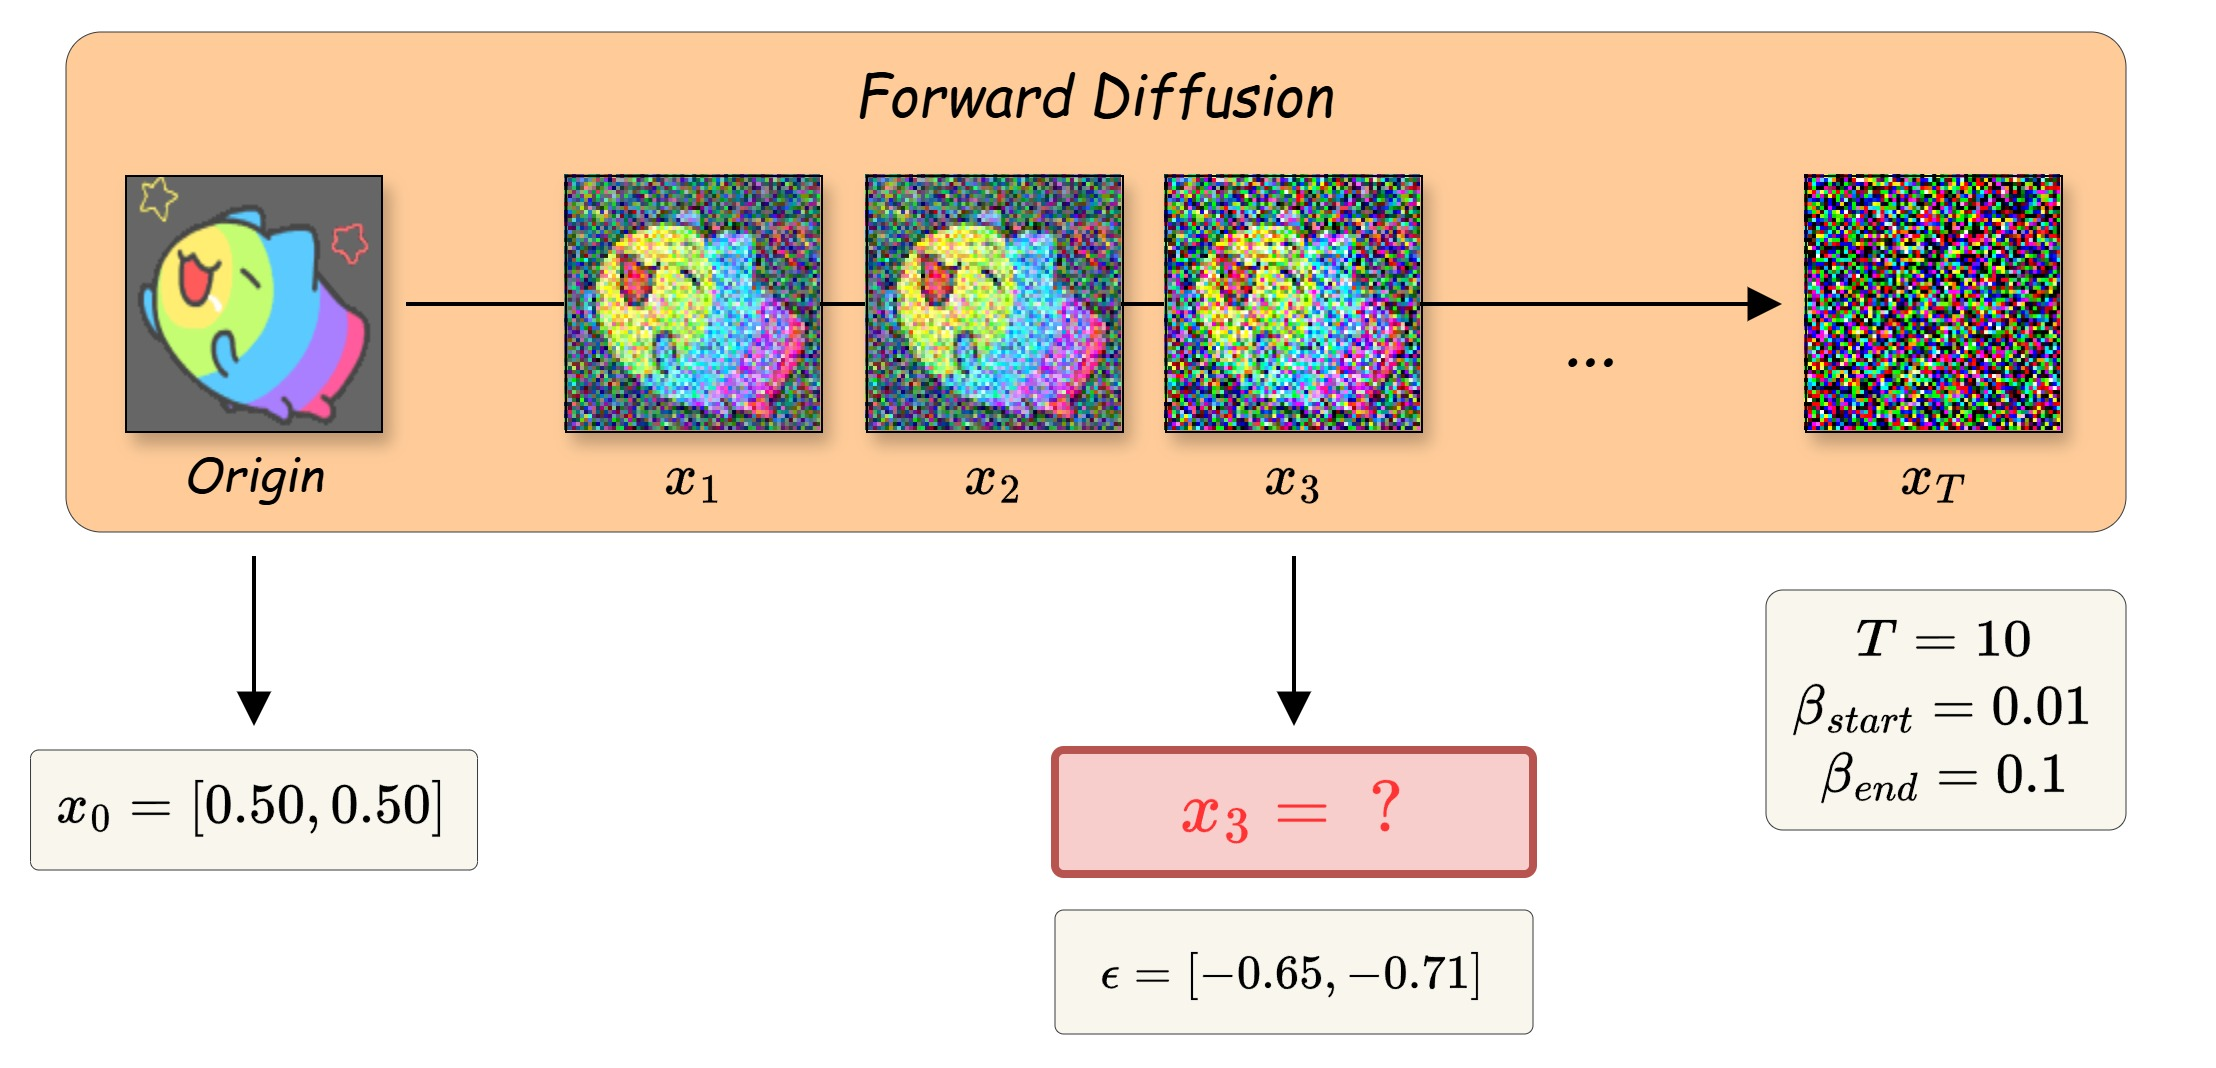

In [ ]:
x_0 = torch.Tensor([0.500, 0.500])
noise_scheduler.forward_diffusion(x_0, 2)


x0:                                     [0.500, 0.500]
noise:                                  [-0.650, -0.710]
sqrt_alphas_cumprod[t]:                 0.970
sqrt_one_minus_alphas_cumprod[t]:       0.243
noisy_x:                                tensor([[0.3270, 0.3120]])


## Câu hỏi 2:
**Mô tả:** Hình bên mô tả quá trình khử nhiễu qua từng bước (step) $t$ sau khi đã làm nhiễu ảnh đầu vào thành nhiễu hoàn toàn (pure noise) sau $T$ bước trước đó. Cụ thể hơn, mô hình sẽ khử nhiễu một cách tuần tự theo từng step, nghĩa là đầu tiên mô hình nhận pure noise làm đầu vào và trả về $x_9$ đã giảm bớt nhiễu, sau đó, tiếp tục nhận $x_9$ làm đầu vào và trả về $x_8$, tương tự như thế cho tới khi nhận được ảnh $x_0$ (generation).

Cho trước các siêu tham số sau:
*   $T=10$ bước.
*   Mức độ nhiễu từ $\beta_{start}=0.01$ đến $\beta_{end}=0.1$.
*   Ảnh đã thêm nhiễu $x_8$.
*   $\epsilon_{\theta}$ là nhiễu được mô hình dự đoán khi nhận đầu vào là $x_8$.
*   Luôn cố định $\epsilon$ khi dùng Parameterization Trick với giá trị như trong hình.


**Yêu cầu:**

1. Làm tròn đến **3** chữ số thập phân cho mỗi bước tính.
2. Hãy tính $x_7$ và chọn đáp án đúng gần nhất.


**Trắc nghiệm**:

A. $[-0.534, -0.605]$

B. $[-0.519, -0.588]$

C. $[-0.505, -0.573]$

D. $[-0.450, -0.513]$

**Đáp án: B**

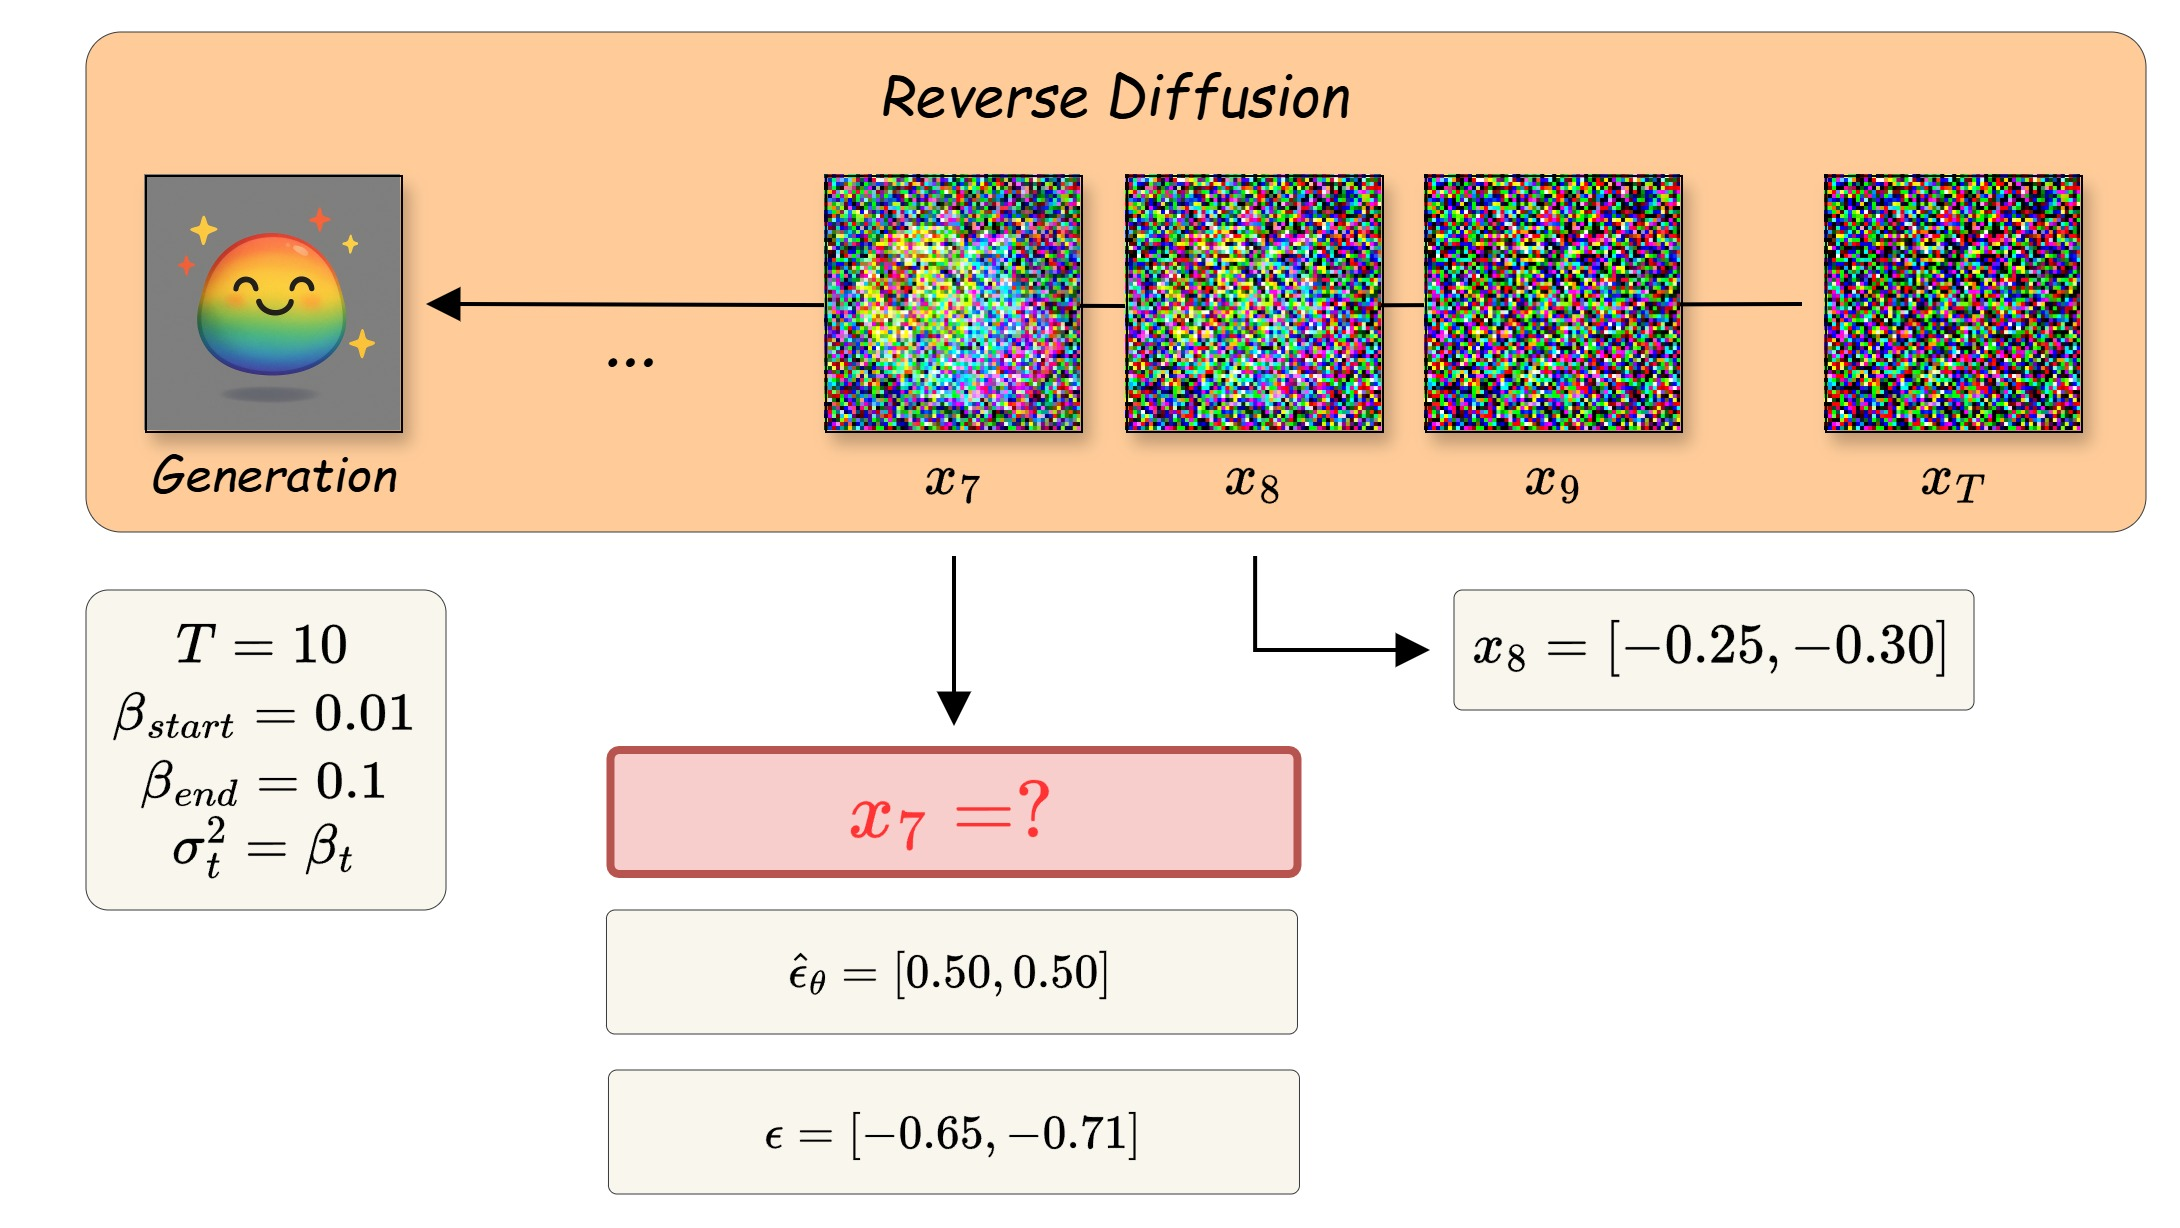

In [ ]:
noise_scheduler.reverse_diffusion(current_timestep=7,
                                  current_latents=torch.Tensor([-0.25, -0.30]),
                                  noise_prediction=torch.Tensor([0.50, 0.50]))


current_timestep:                       7
previous_timestep:                      6
cumprod_alpha_current:                  0.690
cumprod_alpha_previous:                 0.750
cumprod_beta_current:                   0.310
cumprod_beta_previous:                  0.250
current_alpha_ratio:                    0.920
current_beta_ratio:                     0.080
predicted_x0:                           [-0.636, -0.696]
original_coefficient:                   0.223
latent_coefficient:                     0.774
--> prior_mean_prediction:              [-0.335, -0.387]
variance_term:                          [-0.184, -0.201]
prior_sample_prediction:                [-0.519, -0.588]
